# CS224N Assignment 1: Exploring Word Vectors (25 Points)

Welcome to CS224n! 

Before you start, make sure you read the README.txt in the same directory as this notebook. 

In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# All the dependencies you need, can be installed by running .
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\JYH\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Please Write Your SUNet ID Here: 

## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *word2vec*. 

**Assignment Notes:** Please make sure to save the notebook as you go along. Submission Instructions are located at the bottom of the notebook.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors (10 points)

Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | START | all | that | glitters | is   | not  | gold  | well | ends | END |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| START    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| END      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add START and END tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine START and END tokens encapsulating each document, e.g., "START All that glitters is not gold END", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

![Picture of an SVD](imgs/svd.png "SVD")

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*. 

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). If you want to learn more thoroughly about PCA or SVD, feel free to check out lectures [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http://theory.stanford.edu/~tim/s15/l/l8.pdf), and [9](https://web.stanford.edu/class/cs168/l/l9.pdf) of CS168. These course notes provide a great high-level treatment of these general purpose algorithms. Though, for the purpose of this class, you only need to know how to extract the k-dimensional embeddings by utilizing pre-programmed implementations of these algorithms from the numpy, scipy, or sklearn python packages. In practice, it is challenging to apply full SVD to large corpora because of the memory needed to perform PCA or SVD. However, if you only want the top $k$ vector components for relatively small $k$ — known as *[Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD)* — then there are reasonably scalable techniques to compute those iteratively.

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds START and END tokens to each of the documents, and lowercases words. You do **not** have perform any other kind of pre-processing.

In [2]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [3]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [6]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    corpus_words = sorted(list(set([y for x in corpus for y in x])))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [7]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted(list(set(["START", "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", "END"])))
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors. If you're not familiar with NumPy, there's a NumPy tutorial in the second half of this cs231n [Python NumPy tutorial](http://cs231n.github.io/python-numpy-tutorial/).


In [14]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}
    # ------------------
    # Write your implementation here.
    M = np.zeros((num_words,num_words))
    for i,word in enumerate(words):
        word2Ind[word] = i
        
    for f in corpus:
        for i,w in enumerate(f):
            left = i-window_size
            right = i+window_size
            if(left<0): left=0
            if(right>=len(f)): right=len(f)-1
                
            for k in range(left,i):
                M[word2Ind[w],word2Ind[f[k]]] += 1
            for k in range(i+1,right+1):
                M[word2Ind[w],word2Ind[f[k]]] += 1
                
    # ------------------

    return M, word2Ind

In [15]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array( 
    [[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,],
     [0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,],
     [0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,]]
)
word2Ind_ans = {'All': 0, "All's": 1, 'END': 2, 'START': 3, 'ends': 4, 'glitters': 5, 'gold': 6, "isn't": 7, 'that': 8, 'well': 9}

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings. 

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [19]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
        # ------------------

    print("Done.")
    return M_reduced

In [20]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["START All that glitters isn't gold END".split(" "), "START All's well that ends well END".split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [52]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    fig,ax = plt.subplots(1)
    wordIndex = [word2Ind[w] for w in words]
    x = [M_reduced[w][0] for w in wordIndex]
    y = [M_reduced[w][1] for w in wordIndex]
    ax.scatter(x, y,marker='x',color='r')
    for i,j,w in zip(x,y,words):
        ax.annotate(w,xy=(i,j))
    plt.show()
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:


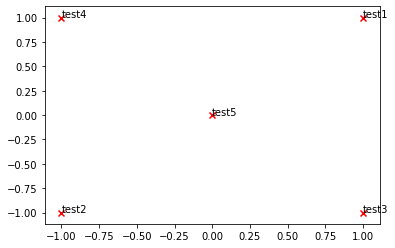

--------------------------------------------------------------------------------


In [53]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4, over the Reuters "crude" corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


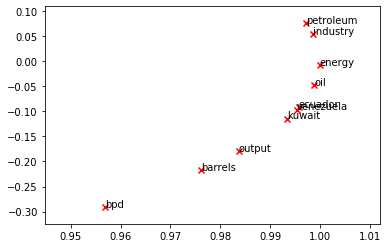

In [54]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have come into fashion, e.g. word2vec. Here, we shall explore the embeddings produced by word2vec. Please revisit the class notes and lecture slides for more details on the word2vec algorithm. If you're feeling adventurous, challenge yourself and try reading the [original paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Then run the following cells to load the word2vec vectors into memory. **Note**: This might take several minutes.

In [25]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin

In [26]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This may take several minutes
# -----------------------------------
wv_from_bin = load_word2vec()

[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded vocab size 3000000


**Note: If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. If you still have problems with loading the embeddings onto your local machine after this, please follow the Piazza instructions, as how to run remotely on Stanford Farmshare machines.**

### Reducing dimensionality of Word2Vec Word Embeddings
Let's directly compare the word2vec embeddings to those of the co-occurrence matrix. Run the following cells to:

1. Put the 3 million word2vec vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 300-dimensional to 2-dimensional.

In [28]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [29]:
# -----------------------------------------------------------------
# Run Cell to Reduce 300-Dimensinal Word Embeddings to k Dimensions
# Note: This may take several minutes
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


### Question 2.1: Word2Vec Plot Analysis [written] (4 points)

Run the cell below to plot the 2D word2vec embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix?

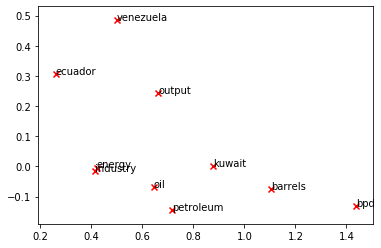

In [55]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced, word2Ind, words)

#### <font color="red">Write your answer here.</font>

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective L1 and L2 Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

<img src="imgs/inner_product.png" width=20% style="float: center;"></img>

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

### Question 2.2: Polysemous Words (2 points) [code + written] 
Find a [polysemous](https://en.wikipedia.org/wiki/Polysemy) word (for example, "leaves" or "scoop") such that the top-10 most similar words (according to cosine similarity) contains related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous words before you find one. Please state the polysemous word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous words you tried didn't work?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [47]:
# ------------------
# Write your polysemous word exploration code here.

wv_from_bin.most_similar("book")

# ------------------

[('tome', 0.7485830783843994),
 ('books', 0.7379177808761597),
 ('memoir', 0.730292797088623),
 ('paperback_edition', 0.6868364810943604),
 ('autobiography', 0.6741527318954468),
 ('memoirs', 0.6505153179168701),
 ('Book', 0.6479282379150391),
 ('paperback', 0.6471226811408997),
 ('novels', 0.6341458559036255),
 ('hardback', 0.6283079385757446)]

#### <font color="red">Write your answer here.</font>

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful". 

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [39]:
# ------------------
# Write your synonym & antonym exploration code here.

w1 = "talk"
w2 = "tell"
w3 = "listen"
w1_w2_dist = wv_from_bin.distance(w1, w2)
w1_w3_dist = wv_from_bin.distance(w1, w3)

print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

# ------------------

Synonyms talk, tell have cosine distance: 0.4819302558898926
Antonyms talk, listen have cosine distance: 0.5545587539672852


#### <font color="red">Write your answer here.</font>

### Solving Analogies with Word Vectors
Word2Vec vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x", what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [40]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399),
 ('crown_prince', 0.5499460697174072),
 ('prince', 0.5377321243286133),
 ('kings', 0.5236844420433044),
 ('Queen_Consort', 0.5235945582389832),
 ('queens', 0.5181134343147278),
 ('sultan', 0.5098593235015869),
 ('monarchy', 0.5087411999702454)]


### Question 2.4: Finding Analogies [code + written]  (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [41]:
# ------------------
# Write your analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['man','queen'], negative=['woman']))

# ------------------

[('king', 0.6958590149879456),
 ('kings', 0.5950952768325806),
 ('queens', 0.5838501453399658),
 ('monarch', 0.5398427248001099),
 ('prince', 0.5223615169525146),
 ('princess', 0.5175285339355469),
 ('princes', 0.49844634532928467),
 ('royal', 0.4924592971801758),
 ('NYC_anglophiles_aflutter', 0.4859851002693176),
 ('Eugene_Ionesco_absurdist_comedy', 0.4784241318702698)]


#### <font color="red">Write your answer here.</font>

### Question 2.5: Incorrect Analogy [code + written] (1 point)
Find an example of analogy that does *not* hold according to these vectors. In your solution, state the intended analogy in the form x:y :: a:b, and state the (incorrect) value of b according to the word vectors.

In [45]:
# ------------------
# Write your incorrect analogy exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=['Anhui','Nanjing'], negative=['Jiangsu']))

# ------------------

[('Anhui_province', 0.6395045518875122),
 ('Chengdu', 0.6027028560638428),
 ('Chongqing', 0.5913376808166504),
 ('Hebei_Province', 0.5803762674331665),
 ('Hefei', 0.5799784660339355),
 ('Anhui_Province', 0.5776181221008301),
 ('Henan', 0.5758872032165527),
 ('Lanzhou', 0.5750921368598938),
 ('Guiyang', 0.5682463645935059),
 ('Shenyang', 0.5671020746231079)]


#### <font color="red">Write your answer here.</font>

### Question 2.6: Guided Analysis of Bias in Word Vectors [written] (1 point)

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit to our word embeddings.

Run the cell below, to examine (a) which terms are most similar to "woman" and "boss" and most dissimilar to "man", and (b) which terms are most similar to "man" and "boss" and most dissimilar to "woman". What do you find in the top 10?

In [46]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'boss'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.45940813422203064),
 ('Manageress', 0.45598435401916504),
 ('receptionist', 0.4474116563796997),
 ('Jane_Danson', 0.44480544328689575),
 ('Fiz_Jennie_McAlpine', 0.44275766611099243),
 ('Coronation_Street_actress', 0.44275566935539246),
 ('supremo', 0.4409853219985962),
 ('coworker', 0.43986251950263977)]

[('supremo', 0.6097398400306702),
 ('MOTHERWELL_boss', 0.5489562153816223),
 ('CARETAKER_boss', 0.5375303626060486),
 ('Bully_Wee_boss', 0.5333974361419678),
 ('YEOVIL_Town_boss', 0.5321705341339111),
 ('head_honcho', 0.5281980037689209),
 ('manager_Stan_Ternent', 0.525971531867981),
 ('Viv_Busby', 0.5256162881851196),
 ('striker_Gabby_Agbonlahor', 0.5250812768936157),
 ('BARNSLEY_boss', 0.5238943099975586)]


#### <font color="red">Write your answer here.</font>

### Question 2.7: Independent Analysis of Bias in Word Vectors [code + written]  (2 points)

Use the `most_similar` function to find another case where some bias is exhibited by the vectors. Please briefly explain the example of bias that you discover.

In [ ]:
# ------------------
# Write your bias exploration code here.

pprint.pprint(wv_from_bin.most_similar(positive=[], negative=[]))
print()
pprint.pprint(wv_from_bin.most_similar(positive=[], negative=[]))

# ------------------

#### <font color="red">Write your answer here.</font>

### Question 2.8: Thinking About Bias [written] (1 point)

What might be the cause of these biases in the word vectors?

#### <font color="red">Write your answer here.</font>

# <font color="blue"> Submission Instructions</font>

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your SUNET ID above.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of ll cells). 
4. Select Cell -> Run All. This will run all the cells in order, and will take several minutes.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are there, displayed correctly. The PDF is the only thing your graders will see!
7. Submit your PDF on Gradescope.